In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

# New York City Temperature Forecast

The aim of this notebook is to forecast NYC monthly temperature using Facebook's Prophet using Earth surface temperature data.

# Data set

The data is available here https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [18]:
df = pd.read_csv('./../data/GlobalLandTemperaturesByCity.csv')
df = df[df['City'] == 'New York']

# Pre-processing

Filter data by date (using recent surface temperature: after 1970).

In [19]:
df['dt'] = pd.to_datetime(df['dt'])
df = df[df.dt >= '1970-01-01']

Use only average tempearture

In [20]:
df = df[['dt', 'AverageTemperature']]

Change columns names

In [21]:
df.columns = ['ds', 'y']

# Split Train/ Val/ Test sets

For Train/ Val/ Test sets, keep:
* 12 months data for test
* 48 months data before test for validation
* rest for training

In [22]:
train = df[:-60].copy()
val = df[-60:-12].copy()
test = df[-12:].copy()

# Baseline

We create a baseline forecast with very simple modelling: model that predicts by using n-1 month's temperature.

In [23]:
baseline = val['y'].shift()
baseline.dropna(inplace=True)
baseline.head()

5207153    10.348
5207154     5.133
5207155     0.327
5207156    -5.360
5207157    -0.372
Name: y, dtype: float64

**RMSE**

Calculate RMSE of baseline

In [24]:
def measure_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [25]:
# Using the function with the baseline values
rmse_base = measure_rmse(val.iloc[1:,1],baseline)

The baseline hase a RMSE of 4,9 deg which is quite high..

In [26]:
rmse_base

4.9071492200752465

# Prophet

**Define and fit**

We choose additive model because the plot show that the amplitude of the seasonal variation is independent of the level

In [33]:
fig = px.line(df, x = 'ds', y = 'y',
             title = 'Average monthly tempearture in NYC since 1970')
fig.show()

## Fit

In [34]:
m = Prophet(seasonality_mode="additive", 
            weekly_seasonality=False,
            daily_seasonality=False)
# we coulds decide to add monthly seasonality
#m.add_seasonality(name='monthly', period=12, fourier_order=20)
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


**Make future datframe and predict**

In [35]:
future = m.make_future_dataframe(periods=60, freq = 'MS' )
future.tail()

,ds
520,2013-05-01
521,2013-06-01
522,2013-07-01
523,2013-08-01
524,2013-09-01


In [36]:
forecast = m.predict(future)

Check

In [172]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
520,2013-05-01,15.882789,13.714395,17.877488
521,2013-06-01,20.794804,18.732904,22.884529
522,2013-07-01,23.362447,21.323313,25.263673
523,2013-08-01,22.676761,20.694439,24.625332
524,2013-09-01,18.492474,16.570938,20.551051


## Plot

We plot the forecast with training points (black) and confidence interval. We notice that the model fits well on the overall except on some outliers (negative temperature)

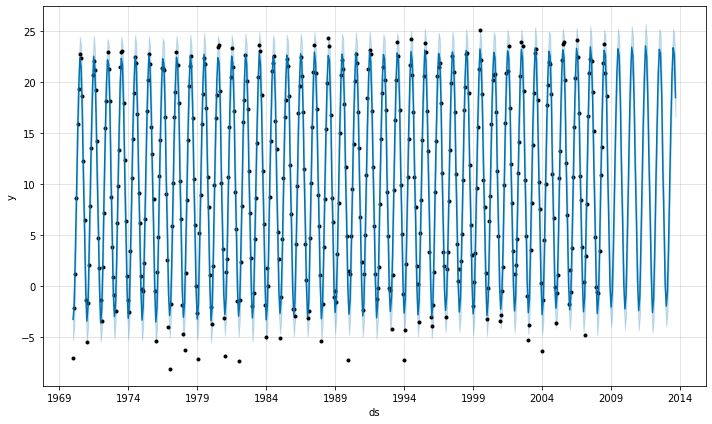

In [173]:
fig1 = m.plot(forecast)

Plot trend component and yearly seasonality component

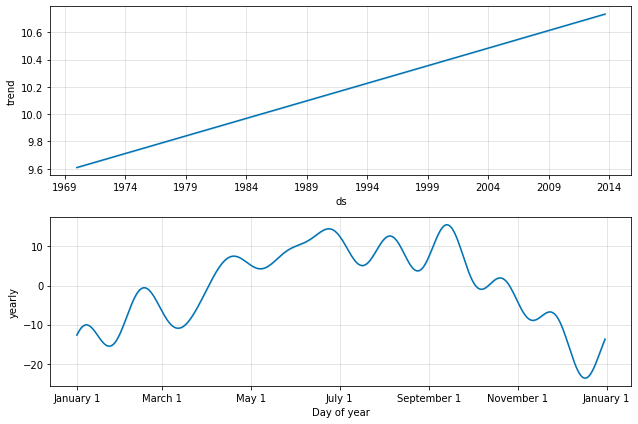

In [174]:
fig2 = m.plot_components(forecast)

## Performance

**Validation set**

# TO DO hyperparameter tuning Prophet

In [175]:
val_res =pd.merge(val, forecast[['ds', 'yhat']], how = 'left', on = 'ds')

We reduced more than 65% the RMSE of baseline

In [176]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val_res['y'], val_res['yhat'])

print(f"The RMSE of the SARIMA model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")

The RMSE of the SARIMA model was 1.5837 celsius degrees
It's a decrease of -67.73% in the RMSE
